<h1 style="font-size:2em">Projet 6 - Classifiez automatiquement des biens de consommation</h1>


# Objectifs

# Imports et configs

In [1]:
import pandas as pd 
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('df.csv', sep = ",")

# Utiliser des techniques d’augmentation des données afin d'améliorer la performance des modèles.

## Création de X

In [4]:
import os
import numpy as np

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from PIL import Image

# Augmenter la limite par défaut (ici, par exemple, fixée à une valeur très élevée)
Image.MAX_IMAGE_PIXELS = None 

def image_prep_fct(df):
    # Définir le chemin d'accès relatif aux images
    base_image_path = "Images"

    prepared_images = []
    for image_name in df['image']:
        # Construire le chemin complet de l'image
        image_path = os.path.join(base_image_path, image_name)

        # Charger, traiter et prétraiter l'image
        img = load_img(image_path, target_size=(224, 224))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)

    prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(df)
X = images_np
print(X.shape)

(1050, 224, 224, 3)


## Création de Y

In [5]:
from sklearn.preprocessing import LabelEncoder

# Initialisation du LabelEncoder
label_encoder = LabelEncoder()

# Convertir les labels texte en labels numériques
y_encoded = label_encoder.fit_transform(df['category_lvl_1'])

# Conversion des labels numériques en one-hot encoding
y = to_categorical(y_encoded)

print(y.shape)

(1050, 7)


## Création de train, validation, test

- 70% pour l'entraînement
- 15% pour la validation
- 15% pour le test

In [6]:
from sklearn.model_selection import train_test_split

X_temp, X_train, y_temp, y_train = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [7]:
print("La forme de X_train est :", X_train.shape)
print("La forme de X_val est :", X_val.shape)
print("La forme de X_test est :", X_val.shape)

La forme de X_train est : (735, 224, 224, 3)
La forme de X_val est : (157, 224, 224, 3)
La forme de X_test est : (157, 224, 224, 3)


## CE1 Vous avez utilisé plusieurs techniques d’augmentation des données (ex. pour des images : rotation, changement d’échelle, ajout de bruit…). 

**Data Augmentation:** Applique différentes techniques de modification des images pour augmenter la diversité des données et aider à prévenir le surapprentissage  
- **RandomFlip:** Effectue un renversement aléatoire (flip) des images horizontalement.
- **RandomRotation:** Fait pivoter l'image de manière aléatoire avec un facteur maximum de 0.1 (36° max)
- **RandomZoom:** Zoom aléatoire avec un facteur maximum de 0.1.

**On construit un modèle séquentiel qui comprend:**
- La partie de data augmentation.
- La couche Rescaling qui recale les valeurs des pixels pour qu'elles soient comprises entre -1 et 1.
- Le modèle VGG16 pré-entraîné.
- GlobalAveragePooling2D: Une couche de mise en commun qui convertit les caractéristiques 2D en un vecteur 1D.
- Une couche Dense de 256 neurones avec une fonction d'activation ReLU.
- Une couche Dropout avec un taux de 0,5 pour prévenir le surapprentissage.
- Une autre couche Dense avec 7 neurones et une activation softmax (Pour classer les images dans 7 classes différentes)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import time

def create_model_fct() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [15]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom

# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [16]:
import time

# Enregistrez l'heure de début
start_time = time.time()

# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

# Enregistrez l'heure de fin
end_time = time.time()

# Calculez et affichez la durée
duration = end_time - start_time
print(f"Le temps d'entraînement est de: {duration:.2f} secondes.")

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 1.8067 - accuracy: 0.2925
Epoch 1: val_loss improved from inf to 1.36321, saving model to .\model1_best_weights.h5
12/12 [==============================] - 19s 1s/step - loss: 1.8067 - accuracy: 0.2925 - val_loss: 1.3632 - val_accuracy: 0.5987
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.3640 - accuracy: 0.5224
Epoch 2: val_loss improved from 1.36321 to 1.07490, saving model to .\model1_best_weights.h5
12/12 [==============================] - 13s 1s/step - loss: 1.3640 - accuracy: 0.5224 - val_loss: 1.0749 - val_accuracy: 0.6624
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.1789 - accuracy: 0.6231
Epoch 3: val_loss improved from 1.07490 to 0.93691, saving model to .\model1_best_weights.h5
12/12 [==============================] - 13s 1s/step - loss: 1.1789 - accuracy: 0.6231 - val_loss: 0.9369 - val_accuracy: 0.7006
Epoch 4/50
12/12 [==============================] - ETA:

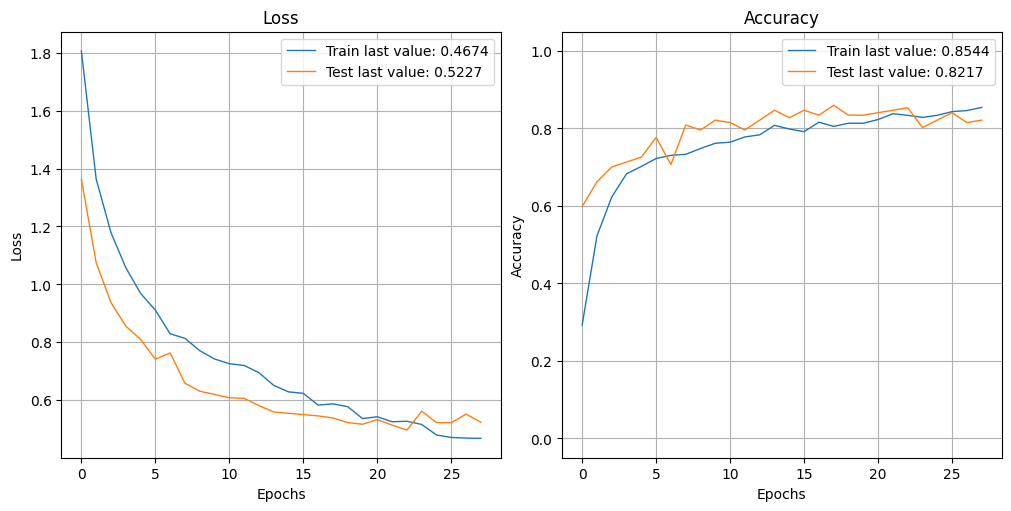

In [17]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [18]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Loss     :  {:.4f}".format(loss))
print("Validation Accuracy :  {:.4f}".format(accuracy))

print("")

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Loss           :  {:.4f}".format(loss))
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Loss     :  0.4960
Validation Accuracy :  0.8535

Test Loss           :  0.7200
Test Accuracy       :  0.7722


In [2]:
import pandas as pd

data = {
    "Modèle": ["Perceptron multicouche", "Modèle simple CNN", "VGG16 + Transfer Learning", "VGG16 + Transfer Learning + DATA AUGMENTATION"],
    "Nb_Epochs": [6, 9, 15, 28],
    "test_loss": [2072.2900, 1.9006, 1.335, 0.7200],
    "test_accuracy": [0.3544, 0.3418, 0.8165, 0.7722],
    "temps (s)": [21.11, 162.67, 1722.07, 368.70]
}

df = pd.DataFrame(data)
df.set_index('Modèle', inplace=True)

def highlight_cells(col):
    # Dictionnaire pour mapper les colonnes aux fonctions appropriées
    mappers = {
        'Nb_Epochs': min,
        'test_loss': min,
        'test_accuracy': max,
        'temps (s)': min
    }
    
    if col.name in mappers:
        criteria = mappers[col.name](col)
        return ['background-color: green' if v == criteria else '' for v in col]
    return [''] * len(col)

styled_df = df.style.apply(highlight_cells)
styled_df


,Nb_Epochs,test_loss,test_accuracy,temps (s)
Modèle,,,,
Perceptron multicouche,6,2072.290000,0.354400,21.110000
Modèle simple CNN,9,1.900600,0.341800,162.670000
VGG16 + Transfer Learning,15,1.335000,0.816500,1722.070000
VGG16 + Transfer Learning + DATA AUGMENTATION,28,0.720000,0.772200,368.700000
